# Predicting Multi-MNIST Digits
_Student 902011, Moleri Andrea, a.moleri@campus.unimib.it_

### Inspecting the Data

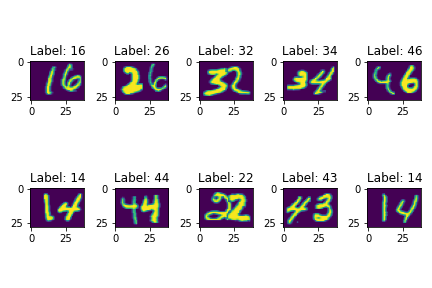

Before we can dive into model development, it's essential to understand the dataset's structure. This dataset is a modified version of MNIST, where each image consists of two concatenated MNIST digits. As a result, the images are `28x39` pixels instead of the typical `28x28`. The training set contains 72,247 samples, while the test set has `24,083` samples. The dataset has `50` class labels, corresponding to different combinations of digits. These labels range from 1 (represented as the concatenation of the digits '0' and '1', hence '01') to `50`. There are some imbalances in the class distribution. For instance, `label 1` has `2,282` samples in the training set, while `label 2` only has `292`. These imbalances might affect model performance, both during training and evaluation. A similar pattern is seen in the test set, where some classes are overrepresented. 

The pixel values have a mean of `45.94` and a standard deviation of `86.29`, with values ranging from `0` (black) to `255` (white). To prevent the model from being influenced by varying scales, the pixel values have been normalized to the range `[0, 1]`. All images have consistent dimensions of `28x39` pixels, making the data easier to process. Some samples from the dataset are displayed along with their respective label at the end of the output of the code cell in order to visually inspect the variety and quality of the images. This understanding of the data at hand is extremely important for building a model, as it informs decisions about handling imbalances, normalization, and image structure.

x_train shape: (72247, 28, 39) (Training samples, Height, Width)
y_train shape: (72247,) (Training labels)
x_test shape: (24083, 28, 39) (Test samples, Height, Width)
y_test shape: (24083,) (Test labels)

Training Class Distribution:
Label 1: 2282 samples
Label 2: 292 samples
Label 3: 2049 samples
Label 4: 1941 samples
Label 5: 1819 samples
Label 6: 641 samples
Label 7: 2102 samples
Label 8: 560 samples
Label 9: 2046 samples
Label 10: 2311 samples
Label 11: 2548 samples
Label 12: 766 samples
Label 13: 358 samples
Label 14: 634 samples
Label 15: 2055 samples
Label 16: 2214 samples
Label 17: 318 samples
Label 18: 471 samples
Label 19: 2403 samples
Label 20: 1982 samples
Label 21: 646 samples
Label 22: 2029 samples
Label 23: 2073 samples
Label 24: 413 samples
Label 25: 555 samples
Label 26: 2034 samples
Label 27: 2132 samples
Label 28: 1926 samples
Label 29: 1979 samples
Label 30: 276 samples
Label 31: 787 samples
Label 32: 832 samples
Label 33: 2159 samples
Label 34: 2050 samples
Label 3

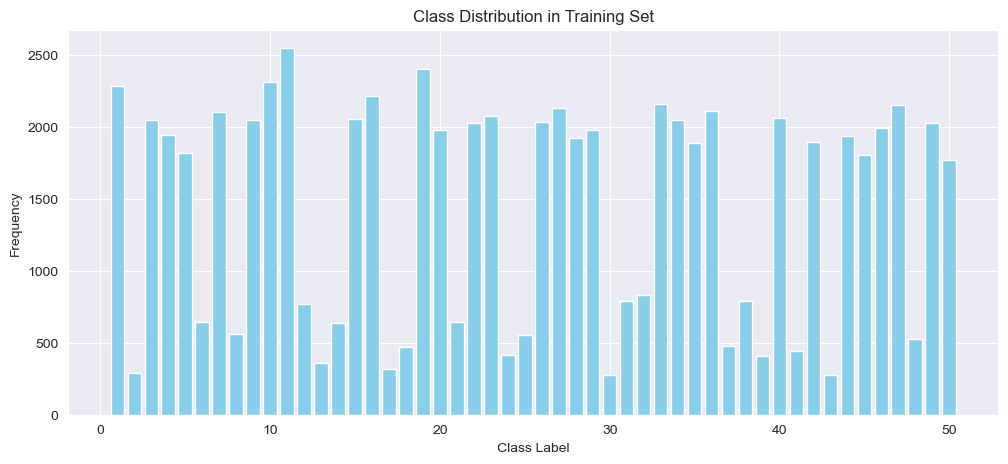


Pixel Value Statistics for Training Set:
Mean pixel value: 45.94
Standard deviation of pixel values: 86.29
Min pixel value: 0
Max pixel value: 255

Unique image shapes in the training set: {(28, 39)}

Unique labels in training set: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50]
Number of unique labels: 50

What follows is a subset of example images taken from the training dataset with their respective labels:


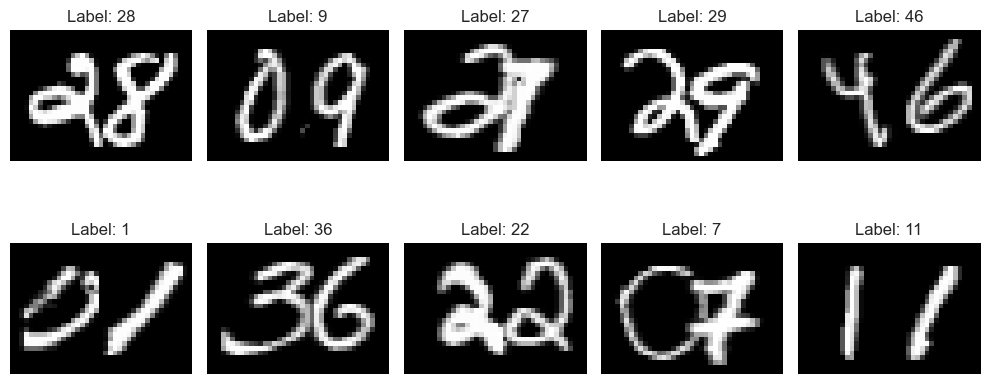

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Load the training and testing datasets
x_train = np.load("./x_train.npy")
x_test = np.load("./x_test.npy")
y_train = np.load("./y_train.npy")
y_test = np.load("./y_test.npy")

# Display the shapes of the training and testing datasets
print(f"x_train shape: {x_train.shape} (Training samples, Height, Width)")
print(f"y_train shape: {y_train.shape} (Training labels)")
print(f"x_test shape: {x_test.shape} (Test samples, Height, Width)")
print(f"y_test shape: {y_test.shape} (Test labels)")

# Compute the distribution of class labels in both training and testing datasets
train_class_distribution = Counter(y_train)
test_class_distribution = Counter(y_test)

# Display the class distribution in the training dataset
print("\nTraining Class Distribution:")
for label, count in sorted(train_class_distribution.items()):
    print(f"Label {label}: {count} samples")

# Display the class distribution in the testing dataset
print("\nTest Class Distribution:")
for label, count in sorted(test_class_distribution.items()):
    print(f"Label {label}: {count} samples")

# Plot the class distribution in the training dataset
plt.figure(figsize=(12, 5))
plt.bar(train_class_distribution.keys(), train_class_distribution.values(), color="skyblue")
plt.xlabel("Class Label")
plt.ylabel("Frequency")
plt.title("Class Distribution in Training Set")
plt.show()

# Display pixel value statistics for the training set
print("\nPixel Value Statistics for Training Set:")
print(f"Mean pixel value: {np.mean(x_train):.2f}")
print(f"Standard deviation of pixel values: {np.std(x_train):.2f}")
print(f"Min pixel value: {np.min(x_train)}")
print(f"Max pixel value: {np.max(x_train)}")

# Identify unique image shapes in the training dataset
unique_shapes = {img.shape for img in x_train}
print("\nUnique image shapes in the training set:", unique_shapes)

# Identify unique class labels in the training dataset
unique_labels = np.unique(y_train)
print("\nUnique labels in training set:", unique_labels)
print(f"Number of unique labels: {len(unique_labels)}")

# Visualize a subset of images from the training dataset with their respective labels
print("\nWhat follows is a subset of example images taken from the training dataset with their respective labels:")

plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis("off")
plt.tight_layout()
plt.show()

### Preparing the Data

During the following preprocessing phase, several steps were applied to get the data ready for training a machine learning model. First, the pixel values of the images were normalized to the range `[0, 1]` by dividing each pixel by `255.0`, the maximum value for 8-bit grayscale images. Normalizing in this way ensures all features have similar scales, helping the model converge more efficiently. The images, initially 2D arrays with dimensions `(28, 39)`, were reshaped into 1D arrays of `1092` elements (`28 * 39`). This flattening step is essential because most machine learning models, especially fully connected networks, expect 1D input vectors rather than 2D matrices.

Labels were clipped to the range `[0, 49]` to ensure only valid classes were included. This ensures that only the digits `1` to `50` are considered valid, as already specified in the `"Inspecting the Data"` section. Next, one-hot encoding was applied to the labels, converting each into a binary vector with a single "1" at the index representing the class. Given `50` classes, each label became a vector of length `50`, allowing the model to predict one class out of many. After these transformations, the training and test sets are correctly shaped: images are now 1-Dimensional vectors of length `1092`, and labels are one-hot encoded with `50` classes. Needless to say, the data at hand has been divided into Train Set, Validation Set and Test Set. It is possible to see the shape of each of these sets in the output of the following code cell.

In [2]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import numpy as np

# Normalize the pixel values to the range [0, 1] by dividing by 255.0
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Reshape the images from 2D (28, 39) to 1D (28*39)
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# Display the maximum value in the training and testing labels
print(f"Max value in y_train: {np.max(y_train)}")
print(f"Max value in y_test: {np.max(y_test)}")

# If the maximum value in the labels is 50, we need to correct this
if np.max(y_train) == 50:
    y_train = np.clip(y_train, 0, 49)  
    y_test = np.clip(y_test, 0, 49) 

# Apply one-hot encoding to the labels for multi-class classification
num_classes = 50  # We know there are 50 classes
y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

# Split the training data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Print the new shapes to confirm that the preprocessing was performed correctly
print(f"Normalized and reshaped x_train shape: {x_train.shape}")
print(f"Normalized and reshaped x_val shape: {x_val.shape}")
print(f"Normalized and reshaped x_test shape: {x_test.shape}")
print(f"One-hot encoded y_train shape: {y_train.shape}")
print(f"One-hot encoded y_val shape: {y_val.shape}")
print(f"One-hot encoded y_test shape: {y_test.shape}")

2024-11-12 08:02:46.376619: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Max value in y_train: 50
Max value in y_test: 50
Normalized and reshaped x_train shape: (57797, 1092)
Normalized and reshaped x_val shape: (14450, 1092)
Normalized and reshaped x_test shape: (24083, 1092)
One-hot encoded y_train shape: (57797, 50)
One-hot encoded y_val shape: (14450, 50)
One-hot encoded y_test shape: (24083, 50)


# 1. Resolving the Supervised Classification Problem with Traditional Fully-Connected NNs

---

💡 You are required to implement two models, without and with the use of one (or more) regularization technique of your choice, and to compare their behaviours, in terms of training dynamics and generalization capabilities.

---

## 1.1 Non-Regularized Model

### 1.1.1 Building the Network

The model starts with an input layer that accepts 1092-dimensional input vectors, representing the flattened pixel values of each image in the dataset. It then includes four hidden dense layers, each using the Rectified Linear Unit (ReLU) activation function, known for its non-linear characteristics and effectiveness in addressing issues like the vanishing gradient (as already seen in the first assignment of this very course). These layers progressively decrease in size—`512`, `256`, `128`, and `64` neurons—to reduce dimensionality as information is processed, allowing for efficient feature extraction while managing the parameter count at the same time. 

A dense output layer with `50` neurons is placed at the end of the network, corresponding to the `50` classes in the Multi-MNIST classification task. This layer uses the softmax activation function, converting the network’s outputs into a probability distribution across the classes, which makes interpreting the output as class probabilities straightforward. For optimization, the Adam optimizer was applied with a learning rate of `0.001`, supporting stable and quick convergence. The categorical cross-entropy loss function, ideal for multi-class tasks with one-hot encoded labels, was used. Accuracy was selected as the evaluation metric, giving a clear measure of the model’s performance by indicating the proportion of correct predictions. As we can see in the output of the following code cell, the model summary shows a total of `735,346` trainable parameters, providing sufficient learning capacity without unnecessary complexity. 

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam

# Create the model
model = Sequential()

# Define the input layer explicitly with the appropriate input shape
model.add(Input(shape=(1092,)))  # The input has a dimensionality of 1092

# First dense layer (hidden layer) with ReLU activation
model.add(Dense(512, activation='relu'))

# Second dense layer (hidden layer) with ReLU activation
model.add(Dense(256, activation='relu'))

# Third dense layer (hidden layer) with ReLU activation
model.add(Dense(128, activation='relu'))

# Fourth dense layer (hidden layer) with ReLU activation
model.add(Dense(64, activation='relu'))

# Output layer with softmax activation for multi-class classification
model.add(Dense(50, activation='softmax'))  # 50 classes for classification

# Compile the model with the Adam optimizer and categorical cross-entropy loss
model.compile(
    optimizer=Adam(learning_rate=0.001),  # Adam optimizer with a learning rate of 0.001
    loss='categorical_crossentropy',  # Loss function for multi-class classification
    metrics=['accuracy']  # Evaluation metric: accuracy
)

# Display the model summary to review its architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               559616    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 50)                3250      
                                                                 
Total params: 735346 (2.81 MB)
Trainable params: 735346 (2.81 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 1.1.2 Analyze and Comment on The Training Results

The training results of the non-regularized model, as presented in the **Training and Validation Loss** and **Training and Validation Accuracy** graphs below the following code cell, offer a clear view of how the model learns over time. Initially, the training loss consistently decreases across epochs, reaching a low of approximately `0.05` by epoch `30-35` (depending on the non-deterministic weight initialization). This steady reduction in loss reflects how well the model minimizes categorical cross-entropy on the training set, as it continues to learn specific features from the data. The validation loss, on the other hand, shows a different pattern. At first, it decreases along with the training loss, suggesting that the model is generalizing effectively. However, pretty soon in the training process, the validation loss begins to fluctuate, signaling that the model may be starting to overfit, focusing too heavily on training data patterns and less on generalizing to new data.

In terms of accuracy, the training accuracy rises predictably throughout the epochs, reaching an accuracy of approximately `98-99%` by the end. This shows that the model is capturing patterns within the training set effectively. The validation accuracy also climbs quickly in the initial epochs, reaching around `94-95%`, but, like validation loss, it soon begins to plateau. This plateau in validation accuracy underscores a limitation in the model's ability to generalize further, as it begins to perform better on training data than on unseen data. The growing gap between training and validation performance reflects a moderate degree of overfitting. While the model performs well on the training data, its ability to generalize effectively to validation data seems to decrease slightly. The **Training and Validation Loss** and **Training and Validation** accuracy graphs confirm our suspicions, with the blue and orange lines having a significant gap between them. To confirm any doubts, the validation loss value (approximately between `0.32` and `0.39`) is also quite high relative to the training loss value (approximately between `0.017` and `0.019`). This trend suggests that introducing regularization techniques, such as `Dropout` or `L2 Regularization`, could help reduce overfitting and enhance the model’s ability to generalize.

_Note: to make the output of the following code cell less verbose and more visually pleasing, a custom `ProgressBar` solution has been implemented. It is still possible to switch back to the traditional view by removing the callback and changing the `verbose` parameters of the Keras API, as specified by the documentation (https://keras.io/api/models/model_training_apis)._

Epoch 35/35 - loss: 0.0160 - accuracy: 0.9948 - val_loss: 0.3536 - val_accuracy: 0.9413

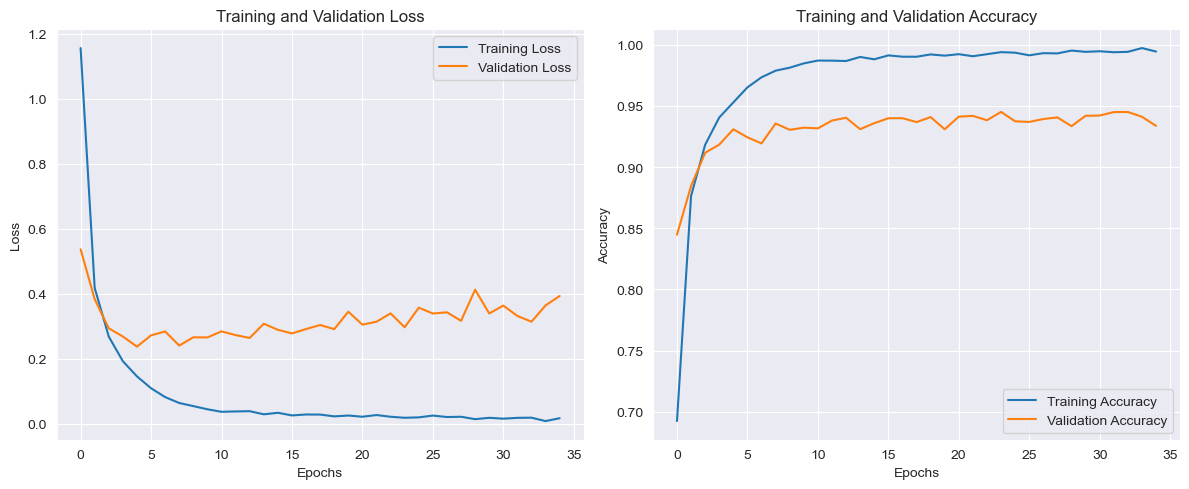

Final training accuracy: 0.9944
Final validation accuracy: 0.9336
Final training loss: 0.0175
Final validation loss: 0.3935


In [4]:
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import Callback

class ProgressBar(Callback):
    """
    A custom callback that displays a rolling average of metrics (e.g., loss, accuracy) at the end of each epoch.
    
    This class is used to provide a smoother display of the metrics during training by computing 
    a rolling average over a defined window of epochs.
    
    Attributes:
    ----------
    rolling_window : int
        The number of recent epochs over which to compute the rolling average.
    metrics_history : dict
        A dictionary that stores the history of the metrics for each metric name.
    """
    
    def __init__(self, rolling_window=5):
        """
        Initializes the ProgressBar with a specified rolling window size.
        
        Parameters:
        -----------
        rolling_window : int, optional
            The number of epochs to consider for the rolling average. Default is 5.
        """
        super(ProgressBar, self).__init__()
        self.rolling_window = rolling_window
        self.metrics_history = {}

    def on_epoch_begin(self, epoch, logs=None):
        """
        This method is called at the start of each epoch. It records the current epoch number.
        
        Parameters:
        -----------
        epoch : int
            The index of the epoch to be started.
        logs : dict, optional
            A dictionary that holds the logs for the epoch.
        """
        self.epoch = epoch

    def _get_rolling_average(self, metric_name, current_value):
        """
        Computes the rolling average of a given metric over the specified window.
        
        This method stores the current value of the metric, maintains a history of the values,
        and computes the average over the most recent values within the rolling window.
        
        Parameters:
        -----------
        metric_name : str
            The name of the metric (e.g., 'accuracy', 'loss').
        current_value : float
            The current value of the metric for the epoch.
        
        Returns:
        --------
        float
            The rolling average of the metric over the defined window.
        """
        if metric_name not in self.metrics_history:
            self.metrics_history[metric_name] = []

        history = self.metrics_history[metric_name]
        history.append(current_value)

        # Ensure the history doesn't exceed the size of the rolling window
        if len(history) > self.rolling_window:
            history.pop(0)

        return sum(history) / len(history)

    def on_epoch_end(self, epoch, logs=None):
        """
        This method is called at the end of each epoch. It computes and prints the rolling average
        of the metrics for the epoch, formatted for display.
        
        Parameters:
        -----------
        epoch : int
            The index of the completed epoch.
        logs : dict, optional
            A dictionary containing the logs for the epoch.
        """
        metrics = []
        for metric_name, value in logs.items():
            avg_value = self._get_rolling_average(metric_name, value)
            metrics.append(f"{metric_name}: {avg_value:.4f}")

        # Display the progress for the current epoch with the rolling averages
        print(f"\rEpoch {self.epoch + 1}/{self.params['epochs']} - " +
              " - ".join(metrics), end='')


# Set training parameters (batch size, number of epochs)
batch_size = 256
epochs = 35 

# Train the model with a validation set
history = model.fit(
    x_train, y_train,  # Training data and corresponding labels
    validation_data=(x_val, y_val),  # Validation data and labels 
    epochs=epochs,  # Number of epochs
    batch_size=batch_size,  # Batch size
    callbacks=[ProgressBar(rolling_window=5)],  # Custom progress bar callback
    verbose=0,  # 0 means no output will be shown during training
    shuffle=True,  # Shuffle the data at the start of each epoch
)

# Visualize the loss and accuracy curves during training
plt.figure(figsize=(12, 5))

# Plot the loss curve
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the accuracy curve
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Summarize and comment on the training results
print(f"Final training accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final validation accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"Final training loss: {history.history['loss'][-1]:.4f}")
print(f"Final validation loss: {history.history['val_loss'][-1]:.4f}")

### 1.1.3 Validate the Model and Comment on The Results

After training the model for `35` epochs, it was evaluated on the (never seen before) test set to evaluate its ability to generalize. The evaluation results are as follows:

- **Test Loss:** approximately between `0.34` and `0.39`
- **Test Accuracy:** approximately between `93%` and `94%`
- **Training Loss:** approximately between `0.017` and `0.019`
- **Training Accuracy:** approximately between `98%` and `99%`

These metrics reflect that the model performs well on data it hasn't encountered during training. Although the test accuracy is high, it's lower than the training accuracy by around `5%`, indicating that the model has not generalized as effectively to the test data. This significant gap between training and test accuracy, coupled with the graphs seen above, suggests **overfitting**. The low training loss value indicates the model has memorized the training data, but the much higher validation loss value (as seen in the output of the previous code cell) and test loss value shows it struggles with new, unseen data. This is typical of models with many parameters and no regularization, as they often learn specific details of the training set rather than general patterns. 

In other words, since the model performs well on training data but poorly on validation data, it's once again clear that **overfitting** is occurring. This means the model has learned the noise in the training data instead of the broader patterns needed for generalization. To mitigate overfitting, regularization techniques like `Dropout` or `L2 Regularization` could be introduced, as suggested in the previous subsection. These methods help prevent the model from becoming overly dependent on specific features and encourage it to learn more generalizable patterns. In this regard, a regularized model will be introduced shortly, and we will see how this model will help solve the problems we are encountering.

In [5]:
# Evaluate the model on the test data 
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)

# Retrieve the final training results
final_train_accuracy = history.history['accuracy'][-1]
final_train_loss = history.history['loss'][-1]

# Evaluate the model's performance on the test set 
print(f"Final Training Accuracy: {final_train_accuracy:.4f}")
print(f"Final Test Accuracy: {test_accuracy:.4f}")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Test Loss: {test_loss:.4f}")

Final Training Accuracy: 0.9944
Final Test Accuracy: 0.9330
Final Training Loss: 0.0175
Final Test Loss: 0.3935


## 1.2 Regularized Model

In this section, the architecture from `Section 1.1` was built upon by adding `L2 Regularization` and `Dropout` layers. These techniques aim to minimize overfitting and enhance the model's generalization. The regularized model follows the same exact structure as the non-regularized one, with two key adjustments:

1. **L2 Regularization** is applied to every dense layer (except the output layer) using different factors, ranging from `0.0001` to `0.00025`. The further you go into the model layers, the more the regularization factor increases. This discourages large weights, helping the model avoid overfitting.
2. **Dropout** layers are added after each dense layer with a varying dropout rate, ranging from `0.2` to `0.3`. The further you go into the model layers, the more the dropout factor increases. Dropout randomly disables a portion of the input units during training, encouraging the model to rely on more robust features and helping to reduce overfitting.

The next steps will be to train the model using the same process as the non-regularized one, and compare the loss, accuracy, and generalization performance. Furthermore, we will visualize the results to understand how the regularization techniques influence the model's ability to generalize to new data.

In [6]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.regularizers import l2

# Define the regularized model with L2 regularization and Dropout
model_reg_optimized = Sequential()

# Add input layer specifying the shape of input features (1092)
model_reg_optimized.add(Input(shape=(1092,)))  

# First hidden layer with 512 units, ReLU activation, L2 regularization, batch normalization, and dropout
model_reg_optimized.add(Dense(512, activation='relu', kernel_regularizer=l2(0.0001)))
model_reg_optimized.add(BatchNormalization())
model_reg_optimized.add(Dropout(0.2)) 

# Second hidden layer with 256 units, ReLU activation, L2 regularization, batch normalization, and increased dropout rate
model_reg_optimized.add(Dense(256, activation='relu', kernel_regularizer=l2(0.00015)))
model_reg_optimized.add(BatchNormalization())
model_reg_optimized.add(Dropout(0.25))  

# Third hidden layer with 128 units, ReLU activation, L2 regularization, batch normalization, and further increased dropout rate
model_reg_optimized.add(Dense(128, activation='relu', kernel_regularizer=l2(0.0002)))
model_reg_optimized.add(BatchNormalization())
model_reg_optimized.add(Dropout(0.3))  

# Fourth hidden layer with 64 units, ReLU activation, L2 regularization, batch normalization, and consistent dropout rate
model_reg_optimized.add(Dense(64, activation='relu', kernel_regularizer=l2(0.00025)))
model_reg_optimized.add(BatchNormalization())
model_reg_optimized.add(Dropout(0.3))

# Output layer with 50 units and softmax activation for multi-class classification
model_reg_optimized.add(Dense(50, activation='softmax'))

# Compile the model
model_reg_optimized.compile(
    optimizer=Adam(learning_rate=0.0005),  
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define EarlyStopping and ReduceLROnPlateau callbacks for improved convergence
early_stopping = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=6)

# Display model summary
model_reg_optimized.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 512)               559616    
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 batch_normalization_1 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 256)              

## 1.3 Compare the Performances of the Two Models

In this section, we evaluate the performance of both the non-regularized and regularized models on the **test set**. The aim is to assess how well each model generalizes to new (unseen) data, focusing on how regularization affects overfitting. For the regularized model, `Early Stopping` and `ReduceLROnPlateau` callbacks were applied to improve convergence and prevent overfitting. `Early Stopping` halts training when validation loss stops improving, while `ReduceLROnPlateau` gradually decreases the learning rate if the validation loss plateaus. Both models were trained for `35` epochs with a batch size of `256`, in order to maintain a significant experimental correlation between them. During training, the loss and accuracy curves were monitored to track learning behaviors and understand how regularization influenced model generalization. The regularized model used two regularization techniques known as `L2 Regularization` and `Dropout` to control complexity and reduce overfitting by penalizing large weights and introducing random neuron dropout during training. Below we see the main differences between the two models:

**Non-Regularized Model**: this model achieved high training accuracy (approximately `99%`) but struggled on the validation and test set, with a test loss that, depending on the non-deterministic weight initialization, oscillates between `0.34` and `0.39`. This, coupled with a lower test accuracy of approximately `93-94%`, indicates that the model overfits the training data. The model fits the training patterns well, but its higher test loss and lower test accuracy suggest a lack of generalization to new data.

**Regularized Model**: in contrast, the regularized model showed better validation and test performance, with a lower test loss that, depending on the non-deterministic weight initialization, oscillates between `0.25` and `0.28`. The model also has an improved test accuracy of approximately `96%`. These results highlight the regularized model’s stronger ability to generalize, supported by its improved test performance.

The regularized model, with its orange validation curves more aligned with the blue training curves, demonstrates a more stable learning process. In contrast, the non-regularized model shows a larger gap between training and validation metrics in the same two plots, signaling a tendency to overfit. Overall, this experiment confirms the importance of regularization techniques in creating models that adapt better to new data.

Epoch 35/35 - loss: 0.1524 - accuracy: 0.9884 - val_loss: 0.2858 - val_accuracy: 0.9574

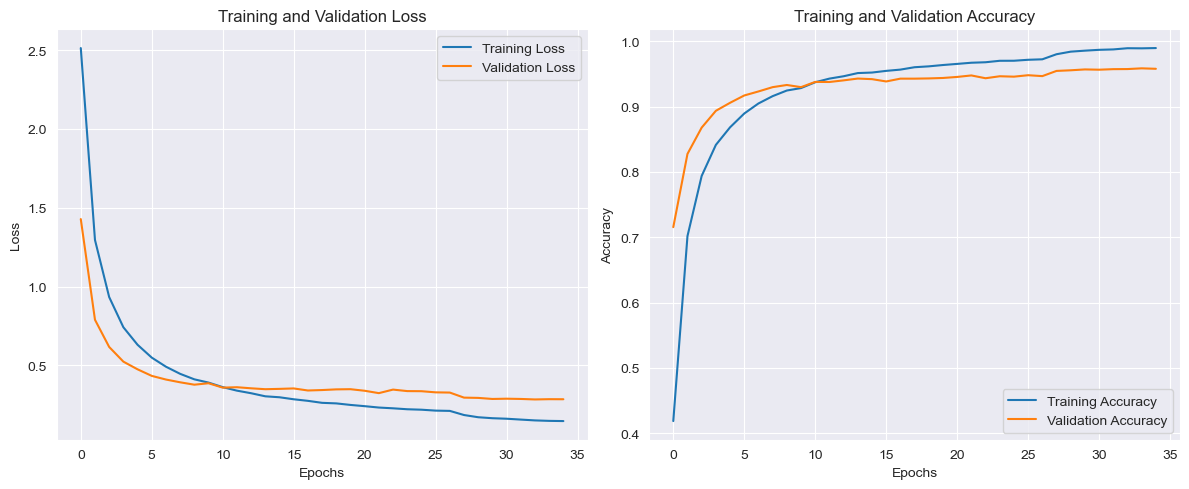

Training completed! Below, we summarize the results of the training process:
Final training accuracy: 0.9894
Final validation accuracy: 0.9577
Final training loss: 0.1465
Final validation loss: 0.2850

Results Comparison on the Test Set:
Non-Regularized Model - Test Loss: 0.3935, Test Accuracy: 0.9330
Regularized Model - Test Loss: 0.2828, Test Accuracy: 0.9591

The regularized model performs better on the test set, indicating better generalization.


In [7]:
# Define training parameters
batch_size = 256
epochs = 35

# Early stopping and ReduceLROnPlateau for better convergence
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Train the regularized model using validation data 
history_reg = model_reg_optimized.fit(
    x_train, y_train,  # Training data and labels
    validation_data=(x_val, y_val),  # Validation data 
    epochs=epochs,  # Number of epochs
    batch_size=batch_size,  # Batch size
    callbacks=[ProgressBar(rolling_window=5), early_stopping, reduce_lr],  # Callbacks for monitoring
    verbose=0,  # 0 means no output during training
    shuffle=True,  # Shuffle the data at the start of each epoch
)

# Visualize the loss and accuracy curves during training
plt.figure(figsize=(12, 5))

# Plot the loss curve
plt.subplot(1, 2, 1)
plt.plot(history_reg.history['loss'], label='Training Loss')
plt.plot(history_reg.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the accuracy curve
plt.subplot(1, 2, 2)
plt.plot(history_reg.history['accuracy'], label='Training Accuracy')
plt.plot(history_reg.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Summarize the training results
print("Training completed! Below, we summarize the results of the training process:")
print(f"Final training accuracy: {history_reg.history['accuracy'][-1]:.4f}")
print(f"Final validation accuracy: {history_reg.history['val_accuracy'][-1]:.4f}")
print(f"Final training loss: {history_reg.history['loss'][-1]:.4f}")
print(f"Final validation loss: {history_reg.history['val_loss'][-1]:.4f}")

# Final evaluation on the test data for both models (non-regularized and regularized)
test_loss_non_reg, test_accuracy_non_reg = model.evaluate(x_test, y_test, verbose=0)  # Non-regularized model evaluation
test_loss_reg, test_accuracy_reg = model_reg_optimized.evaluate(x_test, y_test, verbose=0)  # Regularized model evaluation

# Print the evaluation results for both models on the test set
print("\nResults Comparison on the Test Set:")
print(f"Non-Regularized Model - Test Loss: {test_loss_non_reg:.4f}, Test Accuracy: {test_accuracy_non_reg:.4f}")
print(f"Regularized Model - Test Loss: {test_loss_reg:.4f}, Test Accuracy: {test_accuracy_reg:.4f}")

## Q&A: Analysis of Model Performance

**Q: Based on the results obtained and analyzed during the training and the validation phases, what were your (rather _personal_) expectations with respect to the performances of your models on a blind external test set?**

**A:** Going into the test phase, I expected the regularized model to perform better than the non-regularized one, as the training and validation results indicated significant improvements in generalization. For the non-regularized model, I anticipated a drop in performance due to overfitting, which was evident from the higher validation loss and lower validation accuracy. I thought the regularized model, with various regularization techniques, early stopping, and learning rate adjustment, would perform significantly better, maintaining lower loss and higher accuracy on unseen data. Overall, I wasn't too surprised by the results, as well implemented regularization techniques tends to help the model generalize better on a blind test set, which was confirmed here, as already seen in class.

---

**Q: What are the differences between results on the validation set and the actual result on the test set (if any)? What could have caused them? Briefly motivate your answer.**

**A:** In this case, the validation and test set results were fairly consistent for both models. However, one notable difference was the slight difference in validation loss and accuracy when comparing the test set to the training/validation data. The test set performance was a bit more conservative, reflecting perhaps some natural variability between validation and real-world data. The test set might have contained slightly different or more challenging examples, contributing to a slight discrepancy in performance. This difference is common when models encounter new data that was not part of the training or validation sets, highlighting the real-world complexity that a model might face.

---

**Q: After the comparison, what is the overall "best" model? Why?**

**A:** The overall "best" model is clearly the **regularized model**. It performed significantly better on both the validation set and the test set, showing much lower validation and test loss, and higher validation and test accuracy. The regularization techniques, like Early Stopping and ReduceLROnPlateau, helped the model avoid overfitting, allowing it to generalize much better to unseen data.

---

**Q: For the model that you consider the "best", what are the major sources of error? Are there any classes/labels (or data samples in general) where the model is struggling the most? Why?**

**A:** The major sources of error for the best-performing model are likely related to data samples that are either outliers or represent rare, complex patterns that the model struggles to learn. Despite the regularization techniques, the model might still have difficulty with ambiguous or noisy examples that do not align well with the majority of the training data. These could include edge cases or underrepresented classes in the dataset, which the model may have difficulty generalizing. What is most worrying in this regard is the imbalance in the classes of the dataset, already highlighted by the preliminary phase of inspection of the data of this notebook. If the model faces imbalanced class distributions, it may be more likely to make errors on minority classes, as it could be biased toward predicting the more frequent ones.

# 2. The Development of a Simple Auto-Encoder Model

---

💡 Implement a fully-connected Auto-Encoder architecture, with a **compression factor** (ratio between input size and smallest encoding size) in the **range [20-30]**

---

## 2.1 Building the Network

The following code cell implements and trains a fully-connected autoencoder aimed at achieving a **compression factor** between `20` and `30`, as requested by the assignment. Through a series of dense encoding layers, it reduces the input dimensionality of `1092` to a compressed encoding of `40` units, reaching a compression factor of approximately `27`. The autoencoder consists of encoding and decoding layers:

- **Encoder:** the input layer (of `1092` dimensions) is progressively reduced through layers of `512`, `256`, and `128` units, reaching the final encoding layer of `40` units. Each encoding layer uses **ReLU Activation** to help the model capture complex patterns in the input data.
  
- **Decoder:** the decoder mirrors the encoder in reverse, expanding the `40`-dimensional encoding back to the original size (of `1092` dimensions). The output layer uses a **sigmoid activation** to constrain reconstructed outputs between `0` and `1`, fitting normalized data.

The model is compiled with `Mean Squared Error (MSE)` as the loss function, which quantifies reconstruction quality by measuring average squared differences between original and reconstructed data points. The `Adam Optimizer` is used, because of its efficiency in training deep learning models. Training runs for `50 Epochs` with a batch size of `1024`, a setup chosen for efficient convergence. A validation set is used to monitor generalization. The code outputs the `Training and Validation Loss` and `Training and Validation MSE` curves, displayed in the output of the following code cell.

The plot on the top shows the training and validation loss decreasing consistently, with values converging to approximately between `0.017` and `0.019` for training loss and between `0.017` and `0.019` for validation loss by the final epoch. This similarity between the two losses suggests that the model generalizes well without overfitting, with no signs of instability during training. The plot on the bottom instead displays mean squared error values for both training and validation sets over epochs. By the end of training, MSE values also reaches values between `0.017` and `0.019` for training and around `0.017` and `0.019` for validation as well, indicating low reconstruction error and effective compression. Given the assumptions, we can affirm that the model demonstrates an effective balance between compression and reconstruction quality, reducing dimensionality from `1092` to `40` with minimal loss. The alignment between training and validation metrics confirms the model’s generalization capability.

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1092)]            0         
                                                                 
 dense_10 (Dense)            (None, 512)               559616    
                                                                 
 dense_11 (Dense)            (None, 256)               131328    
                                                                 
 dense_12 (Dense)            (None, 128)               32896     
                                                                 
 dense_13 (Dense)            (None, 40)                5160      
                                                                 
 dense_14 (Dense)            (None, 128)               5248      
                                                                 
 dense_15 (Dense)            (None, 256)               33024 

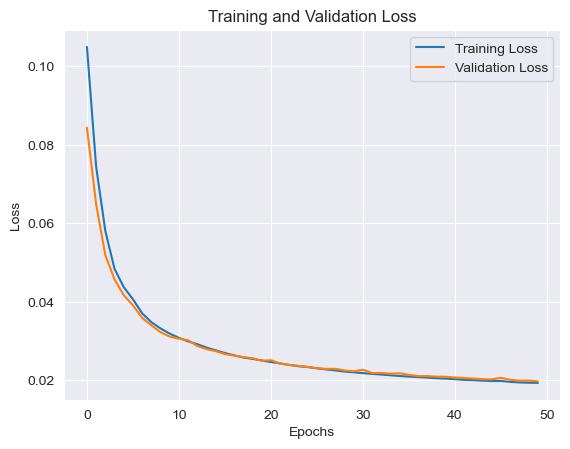

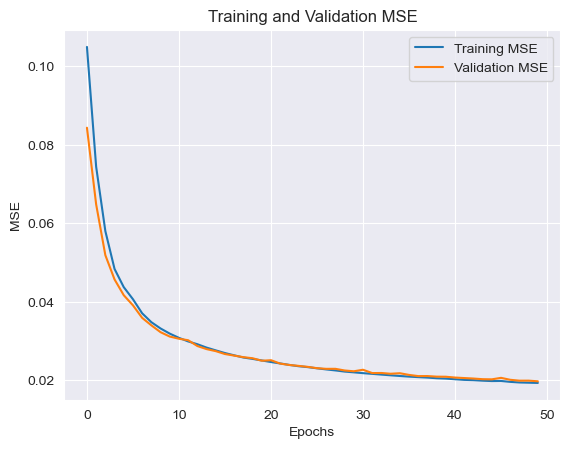

In [8]:
# Set the seed for reproducibility
from numpy.random import seed
import tensorflow as tf

# Chosen seed value for reproducibility
cherry_picked_seed = 1

# Set random seeds for numpy and TensorFlow to ensure reproducible results
seed(cherry_picked_seed)
tf.random.set_seed(cherry_picked_seed)

# Import necessary libraries
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt

# Parameters for the autoencoder
input_dim = 1092  # Set input dimension, adjust based on your dataset
encoding_dim = 40  # Compression factor 
activation = "relu"  # Activation function used in hidden layers

# Define the input layer
input_layer = Input(shape=(input_dim,))

# Encoder: progressively reduce the dimensionality of the input
encoded_1 = Dense(512, activation=activation)(input_layer)  # First encoding layer
encoded_2 = Dense(256, activation=activation)(encoded_1)  # Second encoding layer
encoded_3 = Dense(128, activation=activation)(encoded_2)  # Third encoding layer
encoded = Dense(encoding_dim, activation=activation)(encoded_3)  # Compressed encoding

# Decoder: reconstruct the original input from the encoded representation
decoded_1 = Dense(128, activation=activation)(encoded)  # First decoding layer
decoded_2 = Dense(256, activation=activation)(decoded_1)  # Second decoding layer
decoded_3 = Dense(512, activation=activation)(decoded_2)  # Third decoding layer
decoded = Dense(input_dim, activation='sigmoid')(decoded_3)  # Output layer 

# Create the autoencoder model (encoding and decoding)
autoencoder = Model(input_layer, decoded)

# Create the encoder model to visualize only the compression part
encoder_model = Model(input_layer, encoded)

# Create the decoder model (from the encoded representation to the reconstruction of the input)
decoder_model = Model(encoded, decoded)

# Summarize the autoencoder model's architecture
autoencoder.summary()

# Compile the autoencoder model
autoencoder.compile(optimizer="adam", loss='mse', metrics=['mse'])  # Use mean squared error (MSE) as the loss metric

# Train the autoencoder
history = autoencoder.fit(x_train, x_train,  # Autoencoder is trained with the same data as input and target
                          epochs=50,  # Set number of epochs
                          batch_size=1024,  # Set batch size for training
                          validation_data=(x_test, x_test),  # Use validation data 
                          shuffle=True)  # Shuffle the data at each epoch for better training performance

# Plot the loss curve during training
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the MSE curve during training
plt.plot(history.history['mse'], label='Training MSE')
plt.plot(history.history['val_mse'], label='Validation MSE')
plt.title('Training and Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

## 2.2 Visually Inspecting the Results

In this section, we will assess the reconstruction performance of the trained autoencoder by comparing original test set images with their reconstructed counterparts. The image shown below the code cell presents two rows of handwritten digits: the top row shows the original images, and the bottom row displays the reconstructions made by the autoencoder. To generate these results, a subset of `10` test images was selected. These are processed through the encoder to obtain their encoded representations (code), which are then passed to the decoder to produce the reconstructed images. 

The reconstruction quality was also quantified using **Mean Absolute Error (MAE)** and **Mean Squared Error (MSE)**, which provide a numerical assessment of the model’s accuracy. Lower values of these metrics indicate better reconstruction quality. The reconstruction errors, calculated as MAE = approximately `0.05` and MSE = approximately `0.01`, suggest that the autoencoder has performed well, with minimal loss of information. Visually, the reconstructions demonstrate that the autoencoder has successfully captured the key features of the handwritten digits. This is mainly confirmed by the fact that the readability of the reconstructed digits is almost identical to the original counterpart, demonstrating that the generated autoencoder model is able to correctly encode and reconstruct the data.

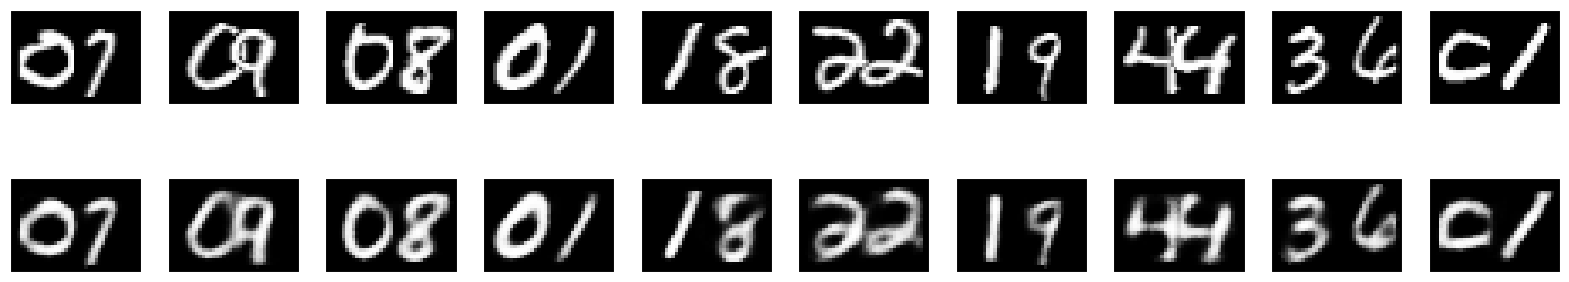

Mean Absolute Error: 0.0554
Mean Squared Error: 0.0163


In [12]:
import matplotlib.pyplot as plt

# Select a subset of images from the test set
x_selected = x_test[:10]  # Select 10 images for analysis

# Obtain the encoded representation and the reconstruction from the autoencoder
encoded_imgs = encoder_model.predict(x_selected, verbose=0) 
decoded_imgs = decoder_model.predict(encoded_imgs, verbose=0)

# Create a figure to visualize the results
plt.figure(figsize=(20, 4))

# Display both the original images and their reconstructed versions
for i in range(10):
    # Original image
    ax = plt.subplot(2, 10, i + 1)
    plt.imshow(x_selected[i].reshape(28, 39))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Reconstructed image
    ax = plt.subplot(2, 10, i + 1 + 10)
    plt.imshow(decoded_imgs[i].reshape(28, 39)) 
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

# Calculate the reconstruction errors
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Compute the MAE and MSE for the reconstructed images
pred = autoencoder.predict(x_selected, verbose=0)

mae = mean_absolute_error(x_selected, pred)
mse = mean_squared_error(x_selected, pred)

print(f'Mean Absolute Error: {mae:.4f}')
print(f'Mean Squared Error: {mse:.4f}')

## 2.3 Generate New Samples

This section examines how the autoencoder generates new, unseen samples starting from random encodings. In other words, by sampling from a normal distribution, we can create new latent encodings and decode them into images. A total of `20` samples are generated and shown for visual inspection. The resulting images broadly resemble the general style and shape of handwritten characters found in the training data, but their quality may vary. This is common with autoencoders, as they often generate outputs that represent an average of the possible reconstructions in the latent space, which can lead to blurry results, as shown in the image below the cell block. The diversity in the generated samples suggests that the model has learned a useful latent space representation, capturing the variation in the data rather than memorizing specific training examples. While this is a positive sign of generalization, the blurry and unsatisfactory outputs reflect the model's difficulty in fully capturing the fine details of the data distribution.

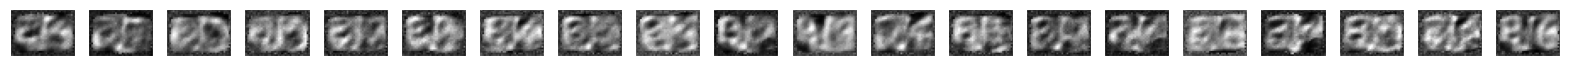

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Number of images to generate
n = 20

# Generate random encodings (latent space representations)
random_encodings = np.random.normal(size=(n, encoding_dim))  # Using a normal distribution for more realistic encodings

# Decode the random encodings to generate the images
decoded_imgs = decoder_model.predict(random_encodings, verbose=0)

# Visualize the generated images
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display the generated images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 39))  # Recall the original shape of the images
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

# 3.A Evaluating Latent Representations for Supervised Classification

In this last code block, the performance of classic machine learning models will be evaluated using the latent representations produced by the autoencoder. By using the encoded features, we aim to assess whether these representations can help in solving the classification task, as compared to directly applying a machine learning model on the original image data. We start by encoding the training and test sets using the autoencoder's encoder module, creating the latent representations `X_train_encoded` and `X_test_encoded`. Next, we train a `RandomForestClassifier` on `X_train_encoded` to predict digits, then evaluate its performance on `X_test_encoded`. For comparison, we apply the same `RandomForestClassifier` to the original data, but with dimensionality reduction through PCA. This step reduces the data to `100` principal components, making it easier for the machine learning model to handle.

Finally, we compare the performance of three models: the one trained on latent representations (`X_train_encoded`), the one trained on PCA-transformed data, and the best model from `Section 1`, the regularized neural network. The comparison is based on accuracy and other classification metrics. The results show that while the latent representations from the autoencoder perform reasonably well, they still lag behind the performance of the regularized neural network that was built in `Section 1`. Both the autoencoder-generated and PCA-based models have room for improvement, suggesting that lower-dimensional representations are challenging for traditional machine learning methods. 

In summary, the model based on latent representations (`~22-24%` accuracy) outperforms the model trained on PCA-transformed features (`~15-17%` accuracy), suggesting that the autoencoder’s encoded features retain more meaningful information for classification. However, the regularised Neural Network Model from `Section 1` continues to perform better (`~95-96%` accuracy) than both of these approaches, as it leverages the full high-dimensional image data. This analysis demonstrates that the autoencoder’s latent representations provide a more informative feature set for classification than PCA, though they still fall short of models trained directly on the high-dimensional image data. This discrepancy implies that while the autoencoder captures some essential class-relevant information, certain details necessary for optimal classification are still lost in the latent space.

In [21]:
# Import necessary libraries for the model and evaluation
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Evaluate the accuracy of the previously optimized model on the test set
_, best_model_accuracy = model_reg_optimized.evaluate(x_test, y_test, verbose=0)

# Encode the training and testing data using the encoder model
X_train_encoded = encoder_model.predict(x_train, verbose=0)
X_test_encoded = encoder_model.predict(x_test, verbose=0)

# Standardize the encoded features to ensure they have a mean of 0 and a standard deviation of 1
scaler = StandardScaler()
X_train_encoded = scaler.fit_transform(X_train_encoded)
X_test_encoded = scaler.transform(X_test_encoded)

# Initialize and train a RandomForestClassifier using the encoded features
clf_latent = RandomForestClassifier(random_state=0, n_estimators=100)
clf_latent.fit(X_train_encoded, y_train)

# Make predictions on the test set using the trained model
y_pred_encoded = clf_latent.predict(X_test_encoded)

# Calculate and display the accuracy of the model based on latent representations
accuracy_encoded = accuracy_score(y_test, y_pred_encoded)
print("\nClassification report for X_train_encoded:\n", classification_report(y_test, y_pred_encoded, zero_division=0))

# Apply PCA for dimensionality reduction, retaining 100 components
pca = PCA(n_components=100, random_state=0)  
X_train_pca = pca.fit_transform(x_train)
X_test_pca = pca.transform(x_test)

# Train a RandomForestClassifier using the data after PCA transformation
clf_pca = RandomForestClassifier(random_state=0, n_estimators=100)
clf_pca.fit(X_train_pca, y_train)

# Make predictions on the test set using the model trained on PCA-transformed data
y_pred_pca = clf_pca.predict(X_test_pca)

# Calculate and display the accuracy of the model based on the original data with PCA applied
accuracy_pca = accuracy_score(y_test, y_pred_pca)
print("Model accuracy on original data with PCA:", accuracy_pca)
print("\nClassification report for original data with PCA:\n", classification_report(y_test, y_pred_pca, zero_division=0))

# Display a performance comparison between the models
print("\nPerformance Comparison:")
print(f"Best Model from Section 1 (Regularized NN Model) - Test Accuracy: {best_model_accuracy:.4f}")
print(f"Model based on latent representations (X_train_encoded) - Test Accuracy: {accuracy_encoded:.4f}")
print(f"Model on original data with PCA - Test Accuracy: {accuracy_pca:.4f}")

Model accuracy on latent representations (X_train_encoded): 0.24174729061993938

Classification report for X_train_encoded:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.99      0.48      0.65       801
           2       0.00      0.00      0.00        77
           3       0.94      0.22      0.36       638
           4       0.96      0.25      0.40       676
           5       1.00      0.05      0.10       606
           6       1.00      0.04      0.08       188
           7       0.98      0.30      0.46       697
           8       1.00      0.01      0.02       185
           9       0.91      0.10      0.18       667
          10       1.00      0.56      0.72       771
          11       0.99      0.76      0.86       876
          12       1.00      0.09      0.16       261
          13       0.00      0.00      0.00        82
          14       0.00      0.00      0.00       202
          